# check on signal quality per concert

derived from http://localhost:8888/notebooks/Stavanger/Signal_Preparation/CardioProcessing.ipynb

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

In [3]:
%reload_ext autoreload

In [4]:
# audio file locations in
datadir = '../Data2024/'
# audio_loc = '../Data2024/Audio/Full_Zero/'
audio_loc = '../Data2024/Audio/Piece_wise/'
# audio file locations out
Event_timings  = pd.read_csv(datadir + 'Timing/Lydo2024_DayEvents.csv',index_col = 0)
Event_timings['dTime_start'] = pd.to_datetime(Event_timings['dTime_start'])
Event_timings['dTime_end'] = pd.to_datetime(Event_timings['dTime_end'])
PartDets = pd.read_csv('../Data2024/Participants/Participant_Metadata.csv',index_col=0)

Piece_timings  = pd.read_csv(datadir + 'Timing/Lydo2024_Performance_events_red.csv')
Piece_timings

,Event,Related,Event_Type,Full_Title,Composer,Performer,Screen,RD,C1,C2,C3,C4,C5,C6,C7
0,Tuning,Conc,Music,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Marsj,Trad,Music,Gammel Jegermarsj,arr. Frederik Schöildberg (?),NaN,NaN,589.203333,45.320000,41.868,46.013333,42.478500,48.032000,41.860000,43.392000
2,MC,Trad,Speech,NaN,NaN,NaN,NaN,606.933333,63.086667,59.780,64.253333,60.690000,65.960000,59.901333,61.077333
3,Ringe,Intr,Music,NaN,NaN,NaN,NaN,612.912000,77.263333,88.020,76.248667,74.331000,79.840000,73.653333,75.242667
4,MC,Intr,Speech,NaN,NaN,NaN,NaN,615.216000,82.033333,93.982,81.013333,79.189333,85.168000,77.888000,79.914667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,MC,Ross,Speech,NaN,NaN,NaN,NaN,3334.570667,2738.355000,2740.158,2704.221000,2675.220000,2632.998667,2644.581333,2765.760000
62,Wilhelm Tell,Ross,Music,Guillaume Tell Ouverture,Gioachino Rossino,NaN,NaN,3340.416000,2744.637000,2746.438,2711.202000,2680.788000,2639.896000,2650.144000,2770.816000
63,Applause,Ross,Applause,NaN,NaN,NaN,NaN,3738.709333,3149.079000,3142.804,3122.261333,3084.543000,3036.590667,3043.656000,3164.588000
64,MC,Conc,Speech,NaN,NaN,NaN,NaN,3746.026667,3164.244000,3161.904,3139.650000,3102.421333,3056.760000,3064.002667,NaN


In [6]:
data_dir='/Volumes/TaeTae/Stavangar/bic2024/'
sep = '/'
DATAtag='EQDATA'
# df_datafiles = eq.eq_recordings(data_dir,DATAtag,sep)
# df_datafiles.iloc[:5,:]

concert_loc = {
    'RD':data_dir + '/RD/',
    'C1':data_dir + '/C1/',
    'C2':data_dir + '/C2/',
    'C3':data_dir + '/C3/',
    'C4':data_dir + '/C4/',
    'C5':data_dir + '/C5/',
    'C6':data_dir + '/C6/',
    'C7':data_dir + '/C7/'}

# concerts = list(concert_loc.keys())
concerts =['RD', 'C3', 'C4', 'C5', 'C6', 'C7']

In [7]:
datafile_type = 'CIBI' # EQCIBI and MSCIBI
piece = 'Full'
concert = 'C3'
data_loc = concert_loc[concert]

# first find data for each participant for that concert
sig_folders = {}
for c in concerts:
    data_loc = concert_loc[c]
    files = os.listdir(data_loc)
    files.sort()
    sig_files = {}
    for f in files: 
        if f.endswith(datafile_type+'.csv'): 
            partID = f.split('_')[2]
            sig_files[partID] = data_loc+f
    sig_folders[c] = sig_files.copy()

In [8]:
Piece_timings

,Event,Related,Event_Type,Full_Title,Composer,Performer,Screen,RD,C1,C2,C3,C4,C5,C6,C7
0,Tuning,Conc,Music,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Marsj,Trad,Music,Gammel Jegermarsj,arr. Frederik Schöildberg (?),NaN,NaN,589.203333,45.320000,41.868,46.013333,42.478500,48.032000,41.860000,43.392000
2,MC,Trad,Speech,NaN,NaN,NaN,NaN,606.933333,63.086667,59.780,64.253333,60.690000,65.960000,59.901333,61.077333
3,Ringe,Intr,Music,NaN,NaN,NaN,NaN,612.912000,77.263333,88.020,76.248667,74.331000,79.840000,73.653333,75.242667
4,MC,Intr,Speech,NaN,NaN,NaN,NaN,615.216000,82.033333,93.982,81.013333,79.189333,85.168000,77.888000,79.914667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,MC,Ross,Speech,NaN,NaN,NaN,NaN,3334.570667,2738.355000,2740.158,2704.221000,2675.220000,2632.998667,2644.581333,2765.760000
62,Wilhelm Tell,Ross,Music,Guillaume Tell Ouverture,Gioachino Rossino,NaN,NaN,3340.416000,2744.637000,2746.438,2711.202000,2680.788000,2639.896000,2650.144000,2770.816000
63,Applause,Ross,Applause,NaN,NaN,NaN,NaN,3738.709333,3149.079000,3142.804,3122.261333,3084.543000,3036.590667,3043.656000,3164.588000
64,MC,Conc,Speech,NaN,NaN,NaN,NaN,3746.026667,3164.244000,3161.904,3139.650000,3102.421333,3056.760000,3064.002667,NaN


In [9]:
sig_files = sig_folders[concert].copy()    
sigName = 'CIBI'
C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 10
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
C_times

,Event,Event_Type,Related,C3
0,Tuning,Music,Conc,0.000000
1,Marsj,Music,Trad,46.013333
2,MC,Speech,Trad,64.253333
3,Ringe,Music,Intr,76.248667
4,MC,Speech,Intr,81.013333
...,...,...,...,...
57,MC,Speech,Ross,2704.221000
58,Wilhelm Tell,Music,Ross,2711.202000
59,Applause,Applause,Ross,3122.261333
60,MC,Speech,Conc,3139.650000


In [10]:
PartIDs = list(sig_files.keys())
len(PartIDs)#-len(player_order)

30

## check individual cardio details

In [11]:
partN = 1
p =  PartIDs[partN]
print(p)

df_sig = pd.DataFrame(index = time_s)

BR605


In [12]:
V = pd.read_csv(sig_files[p])
sig_t = V['c_sTime']
sig_v = V['Interbeat Interval (MS)']
HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,partID] = f(time_s)

In [13]:
event_palette = {'Applause':(0.388,0.286,0.275),'Speech':(0.263,0.467,0.718),'Music':(0.878,0.482,0.180)}
event_hatching = {'Applause':'xx', 'Speech':'', 'Music':'...'}
bpm_range = [40,180]

In [14]:
concert = 'C4'

In [15]:

sig_files = sig_folders[concert].copy()   

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 10
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']
# C_times

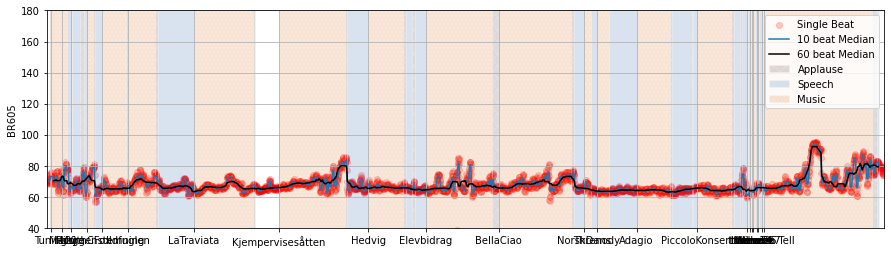

In [16]:
event_times = C_times[concert]
event_types = C_times['Event_Type']
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

V = pd.read_csv(sig_files[p])
sig_t = V['c_sTime']
sig_v = V['Interbeat Interval (MS)']
df_sig = pd.DataFrame(index = time_s)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,4])
ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,'10 beat Median'] = f(time_s)
df_sig.plot(ax = ax1)

HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,'60bMed'] = f(time_s)
df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 beat Median')

time_start =  event_times[0]-5
event_types = event_types
ax1.margins(0)
for ev in event_palette.keys():
    ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
ax1.legend()

for i in range(len(event_times)-1):
    et = event_types[i]
    if et in event_palette.keys():
        ei= event_times.iloc[i]
        ej = event_times.iloc[i+1]
        ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
ax1.set_ylim(bpm_range)
ax1.set_ylabel(p)

M_times = C_times.loc[C_times['Event_Type']=='Music',:]

ax1.set_xticks(M_times[concert])
ax1.set_xticklabels(M_times['Event'])
ax1.grid()

plt.show()

BR605


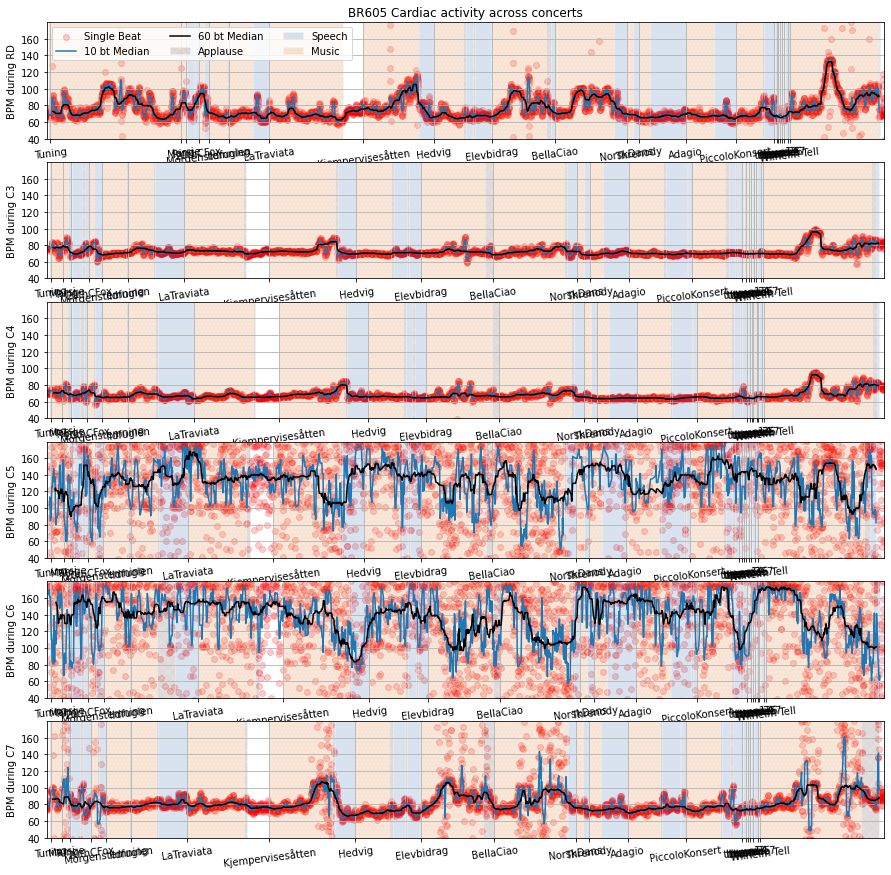

In [17]:
datafile_type = 'CIBI'
bpm_range = [40,180]
partID =  PartIDs[partN]
print(partID)

fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

for j in range(len(concerts)):
    concert = concerts[j]

    C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
    C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
    M_times = C_times.loc[C_times['Event_Type']=='Music',:]
    event_times = C_times[concert]
    event_types = C_times['Event_Type']
    
    s_time = -15 #C_times.loc[0,concert]
    e_time = C_times[concert].iloc[-1]
    dur = e_time - s_time
    time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
    
    data_loc = concert_loc[concert] + piece + '/'
    sig_files = sig_folders[concert].copy() 
    if partID in sig_files.keys():
        V = pd.read_csv(sig_files[partID])

        # cut extreme outliers
        V = V.loc[V['Interbeat Interval (MS)']>330,:]
        sig_t = V['c_sTime']
        sig_v = V['Interbeat Interval (MS)']

        df_sig = pd.DataFrame(index = time_s)
        ax1 = ax[j]
        ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

        HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'10 bt Median'] = f(time_s)
        df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

        HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'60bMed'] = f(time_s)
        df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')
        

        
        time_start =  event_times[0]-5
        event_types = event_types
        ax1.margins(0)
        for ev in event_palette.keys():
            ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
        if j == 0:
            #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
            ax1.legend(ncol=3)

        for i in range(len(event_times)-1):
            et = event_types[i]
            if et in event_palette.keys():
                ei= event_times.iloc[i]
                ej = event_times.iloc[i+1]
                ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
        
        ax1.set_ylim(bpm_range)
        ax1.set_yticks([40,60,80,100,120,140,160])
        ax1.set_xticks(M_times[concert])
        ax1.set_xticklabels(M_times['Event'],rotation = 7)
        ax1.grid()
        ax1.set_ylabel('BPM during ' + concert)
        
ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))

plt.savefig('_'.join(['./plots/Cardiac',partID,piece,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)

plt.show()

In [18]:
datafile_type = 'EQCIBI'
piece = 'Full'
sigName = 'CIBI'
bpm_range = [40,170]
for partID in PartIDs:
    print(partID)

    fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

    for j in range(len(concerts)):
        concert = concerts[j]

        C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
        C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
        M_times = C_times.loc[C_times['Event_Type']=='Music',:]
        event_times = C_times[concert]
        event_types = C_times['Event_Type']

        s_time = -15 #C_times.loc[0,concert]
        e_time = C_times[concert].iloc[-1]
        dur = e_time - s_time
        time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

        data_loc = concert_loc[concert] + piece + '/'
        sig_files = sig_folders[concert].copy() 
        if partID in sig_files.keys():
            V = pd.read_csv(sig_files[partID])

            # cut extreme outliers
            V = V.loc[V['Interbeat Interval (MS)']>330,:]
            sig_t = V['c_sTime']
            sig_v = V['Interbeat Interval (MS)']

            df_sig = pd.DataFrame(index = time_s)
            ax1 = ax[j]
            ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

            HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'10 bt Median'] = f(time_s)
            df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

            HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'60bMed'] = f(time_s)
            df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')


            time_start =  event_times[0]-5
            event_types = event_types
            ax1.margins(0)
            for ev in event_palette.keys():
                ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
            if j == 0:
                #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
                ax1.legend(ncol=3)

            for i in range(len(event_times)-1):
                et = event_types[i]
                if et in event_palette.keys():
                    ei= event_times.iloc[i]
                    ej = event_times.iloc[i+1]
                    ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)

            ax1.set_ylim(bpm_range)
            ax1.set_yticks([50,60,70,80,90,100,110,120,130,140,150,160])
            ax1.set_xticks(M_times[concert])
            ax1.set_xticklabels(M_times['Event'],rotation = 7)
            ax1.grid()
            ax1.set_ylabel('BPM during ' + concert)

    ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))
    plt.savefig('_'.join(['./plots/BPM/Cardiac',partID,piece,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)
    plt.close()


BR604
BR605
BR606
BR608
BR609
LS401
LS404
LS405
LS407
LS409
LS410
PC702
PC709
PC710
VA304
VA305
VA309
VN101
VN104
VN105
VN109
VN110
VN111
VN201
VN206
VN211
VN212
WW504
WW506
WW508


In [56]:
sig_files 

{'BR605': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_BR605_EQCIBI.csv',
 'BR608': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_BR608_EQCIBI.csv',
 'LS404': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_LS404_EQCIBI.csv',
 'LS405': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_LS405_EQCIBI.csv',
 'LS409': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_LS409_EQCIBI.csv',
 'LS410': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_LS410_EQCIBI.csv',
 'PC709': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_PC709_EQCIBI.csv',
 'PC710': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_PC710_EQCIBI.csv',
 'VA304': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_VA304_EQCIBI.csv',
 'VA305': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_VA305_EQCIBI.csv',
 'VA309': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_VA309_EQCIBI.csv',
 'VN105': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_VN105_EQCIBI.csv',
 'VN109': '/Volumes/TaeTae/Stavangar/bic2024//C7/C7_FULL_VN109_EQCIBI.csv',
 'VN201': '/

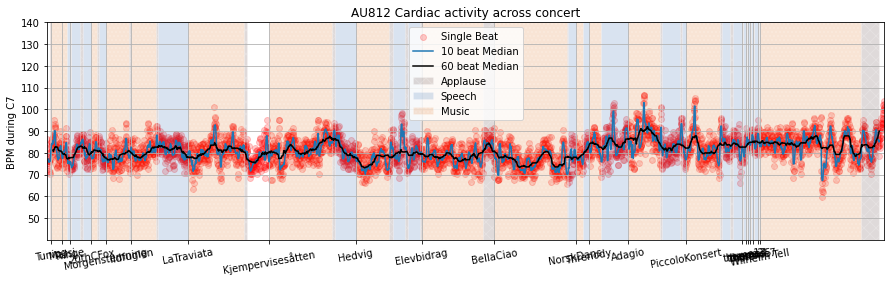

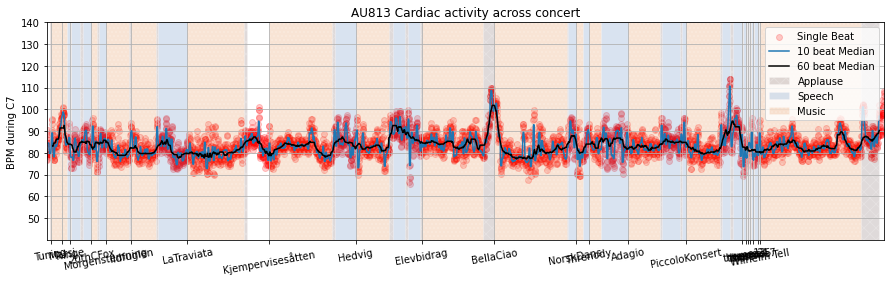

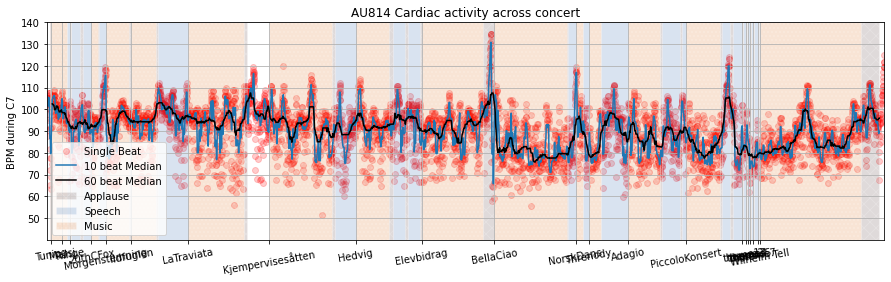

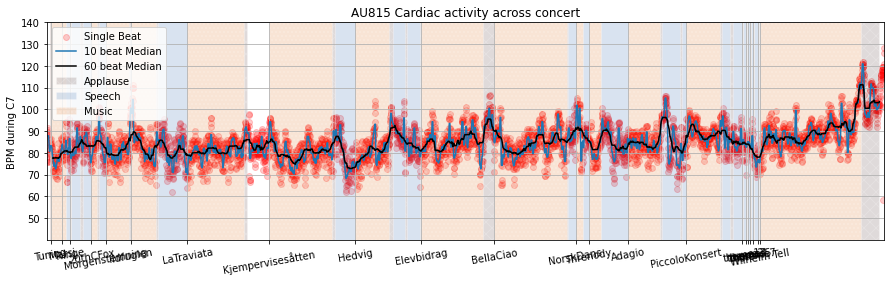

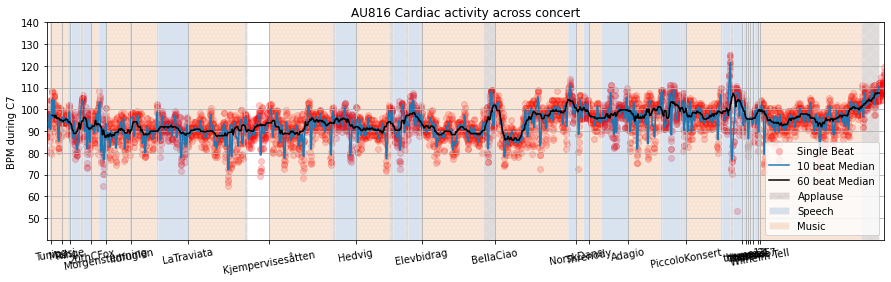

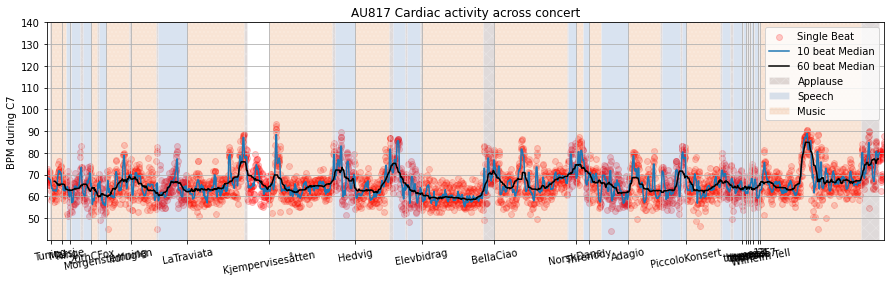

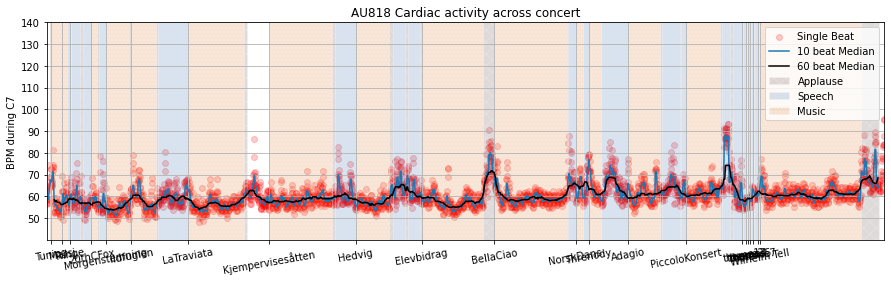

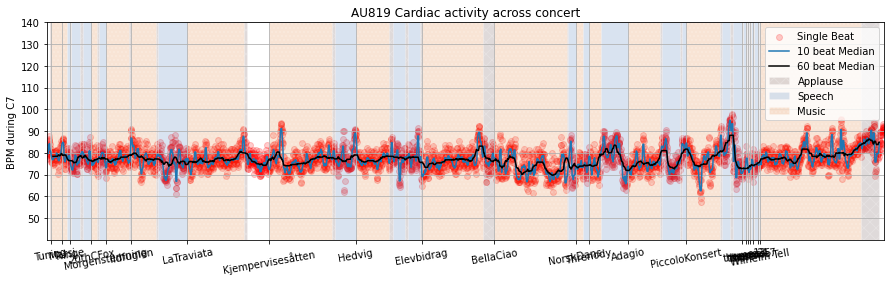

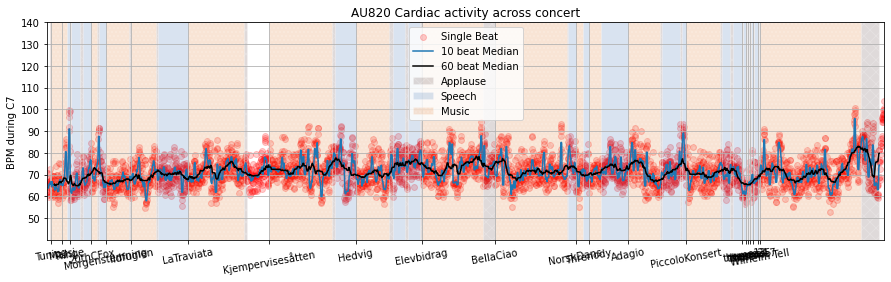

In [69]:
concert = 'C7'
sig_files = sig_folders[concert].copy() 

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]
bpm_range = [40,140]

piece = 'Full'
sf = 10
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']

PartIDs = sig_files.keys()
for p in PartIDs:
    if p.startswith('AU'):
        event_times = C_times[concert]
        event_types = C_times['Event_Type']
        M_times = C_times.loc[C_times['Event_Type']=='Music',:]

        V = pd.read_csv(sig_files[p])
        sig_t = V['c_sTime']
        sig_v = V['Interbeat Interval (MS)']
        df_sig = pd.DataFrame(index = time_s)

        fig, (ax1) = plt.subplots(1, 1,figsize = [15,4])
        ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

        HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'10 beat Median'] = f(time_s)
        df_sig.plot(ax = ax1)

        HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'60bMed'] = f(time_s)
        df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 beat Median')

        time_start =  event_times[0]-5
        event_types = event_types
        ax1.margins(0)
        for ev in event_palette.keys():
            ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
        ax1.legend()

        for i in range(len(event_times)-1):
            et = event_types[i]
            if et in event_palette.keys():
                ei= event_times.iloc[i]
                ej = event_times.iloc[i+1]
                ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
        ax1.set_ylim(bpm_range)
        ax1.set_yticks([50,60,70,80,90,100,110,120,130,140])
        ax1.set_ylabel(p)

        M_times = C_times.loc[C_times['Event_Type']=='Music',:]

        ax1.set_xticks(M_times[concert])
        ax1.set_xticklabels(M_times['Event'],rotation = 10)
        ax1.grid()
        ax1.set_ylabel('BPM during ' + concert)
        ax1.set_title(' '.join([p,'Cardiac activity across concert']))
        plt.savefig('_'.join(['./plots/BPM/Cardiac',p,concert,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)
        plt.show()

In [ ]:
concert = 'C5'
sig_files = sig_folders[concert].copy()   

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 10
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']
# C_times

In [65]:
len(PartIDs)

30

In [ ]:
datafile_type = 'EQCIBI'
piece = 'Full'
sigName = 'CIBI'
bpm_range = [40,170]
for partID in PartIDs:
    print(partID)

    fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

    for j in range(len(concerts)):
        concert = concerts[j]

        C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
        C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
        M_times = C_times.loc[C_times['Event_Type']=='Music',:]
        event_times = C_times[concert]
        event_types = C_times['Event_Type']

        s_time = -15 #C_times.loc[0,concert]
        e_time = C_times[concert].iloc[-1]
        dur = e_time - s_time
        time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

        data_loc = concert_loc[concert] + piece + '/'
        sig_files = sig_folders[concert].copy() 
        if partID in sig_files.keys():
            V = pd.read_csv(sig_files[partID])

            # cut extreme outliers
            V = V.loc[V['Interbeat Interval (MS)']>330,:]
            sig_t = V['c_sTime']
            sig_v = V['Interbeat Interval (MS)']

            df_sig = pd.DataFrame(index = time_s)
            ax1 = ax[j]
            ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

            HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'10 bt Median'] = f(time_s)
            df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

            HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'60bMed'] = f(time_s)
            df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')


            time_start =  event_times[0]-5
            event_types = event_types
            ax1.margins(0)
            for ev in event_palette.keys():
                ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
            if j == 0:
                #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
                ax1.legend(ncol=3)

            for i in range(len(event_times)-1):
                et = event_types[i]
                if et in event_palette.keys():
                    ei= event_times.iloc[i]
                    ej = event_times.iloc[i+1]
                    ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)

            ax1.set_ylim(bpm_range)
            ax1.set_yticks([40,60,80,100,120,140,160])
            ax1.set_xticks(M_times[concert])
            ax1.set_xticklabels(M_times['Event'],rotation = 7)
            ax1.grid()
            ax1.set_ylabel('BPM during ' + concert)

    ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))
    plt.savefig('_'.join(['./plots/BPM/Cardiac',partID,piece,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)
    plt.close()


BR604
BR605
BR606
BR608
BR609
LS401
LS404
LS405
LS407
LS409
LS410
PC702
PC709
PC710
VA304
VA305
VA309
VN101
VN104
VN105
VN109
VN110
VN111
VN201
VN206
VN211
VN212
WW504
WW506
